In [1]:
from os.path import join
from time import perf_counter

import metrics as M
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from scipy.stats import cumfreq

In [2]:
POS = ["prostate_supine", "prostate_upright"]
OBJ = [
    "bladder",
    "femoral_head_l",
    "femoral_head_r",
    "prostate",
    "rectum",
]
CLR = [
    "green",
    "orange",
    "red",
    "blue",
    "purple",
]

In [3]:
def show3D(matrix, title, size=(8, 8), downsample=4):
    matrix = matrix[::downsample, ::downsample, ::downsample]

    labels = np.unique(matrix)
    labels = labels[labels != 0]

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(projection="3d")

    for i, label in enumerate(labels):
        mask = (matrix == label).astype(np.uint8)

        if np.sum(mask) == 0:
            continue

        verts, faces, _, _ = measure.marching_cubes(mask, level=0)

        ax.plot_trisurf(
            verts[:, 0],
            verts[:, 1],
            faces,
            verts[:, 2],
            color=CLR[i],
            linewidth=0,
            antialiased=False,
            alpha=0.9,
        )

    zdim, ydim, xdim = matrix.shape
    ax.set_xlim(0, zdim)
    ax.set_ylim(0, ydim)
    ax.set_zlim(0, xdim)
    ax.set_box_aspect(matrix.shape)

    ax.set_title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def pad(data, gaps):
    return [str(d).ljust(g + 1) for d, g in zip(data, gaps)]


def makeTable(rowNames, rows, labels, rounding=3, minWidth=0):
    for r in range(len(rows)):
        rows[r] = [round(i, rounding) if isinstance(i, float) else i for i in rows[r]]

    gaps = [max(map(len, rowNames))]
    for i in range(len(labels)):
        colMax = len(labels[i])
        for row in rows:
            colMax = max(len(str(row[i])), colMax, minWidth)
        gaps.append(colMax)

    rows = [list(map(str, row)) for row in rows]

    rowSep = "+" + "+".join("-" * (i + 2) for i in gaps) + "+"
    print(rowSep)
    print("| " + "| ".join(pad([""] + labels, gaps)) + "|")
    print(rowSep)
    for name, row in zip(rowNames, rows):
        print("| " + "| ".join(pad([name] + row, gaps)) + "|")
        print(rowSep)

+---------+---------+----------+--------+
|         | Bladder | Prostate | Rectum |
+---------+---------+----------+--------+
| Upright | 0.006   | 0        | 0      |
+---------+---------+----------+--------+
| Supine  | 0       | 0        | 0      |
+---------+---------+----------+--------+


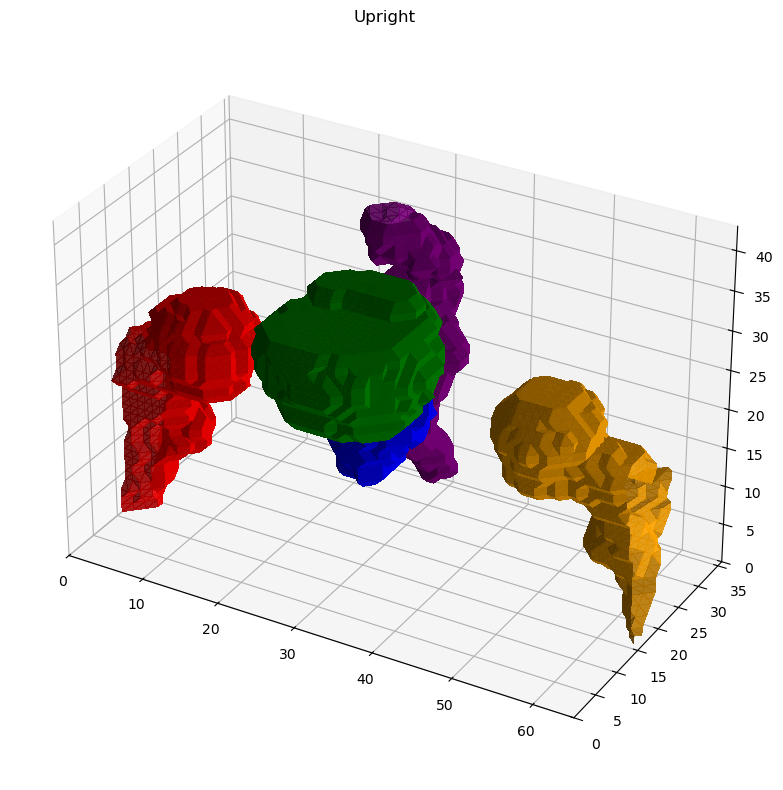

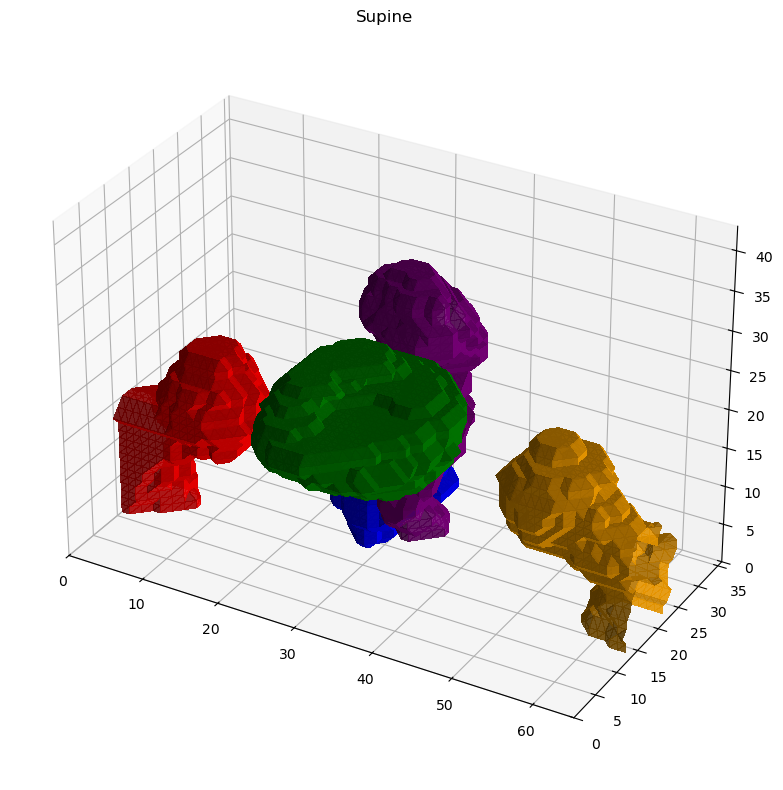

In [5]:
def load(pos, downsample=1):
    files = []
    for obj in OBJ:
        files.append(f"{pos}_{obj}.npy")
    return [
        np.load(join("data", file)).transpose(2, 1, 0)[::downsample, ::downsample, ::downsample]
        for file in files
    ]


masksU = load(POS[0])
masksS = load(POS[1])

combU = np.zeros_like(masksU[0], dtype=int)
combS = np.zeros_like(masksS[0], dtype=int)

for i, m in enumerate(masksU):
    combU[np.where(m)] = i + 1

for i, m in enumerate(masksS):
    combS[np.where(m)] = i + 1

show3D(combU, "Upright")
show3D(combS, "Supine")

# Volumetric / Surface Area Analysis

In [20]:
IDX = [0, 3, 4]

labels = [OBJ[idx].capitalize() for idx in IDX]
rNames = ["Upright Vol", "Supine Vol", "Vol Diff", "Upright SA", "Supine SA", "SA Diff"]

volU = np.array([M.getVolume(masksU[idx]) for idx in IDX])
volS = np.array([M.getVolume(masksS[idx]) for idx in IDX])
volDiff = volU - volS

saU = np.array([M.getSurfaceArea(masksU[idx]) for idx in IDX])
saS = np.array([M.getSurfaceArea(masksS[idx]) for idx in IDX])
saDiff = saU - saS
# print([volU, volS, volDiff, saU, saS, saDiff])
makeTable(rNames, [volU, volS, volDiff, saU, saS, saDiff], labels)

+-------------+---------+----------+--------+
|             | Bladder | Prostate | Rectum |
+-------------+---------+----------+--------+
| Upright Vol | 154820  | 42760    | 95445  |
+-------------+---------+----------+--------+
| Supine Vol  | 166215  | 50735    | 101140 |
+-------------+---------+----------+--------+
| Vol Diff    | -11395  | -7975    | -5695  |
+-------------+---------+----------+--------+
| Upright SA  | 16636   | 6815     | 16667  |
+-------------+---------+----------+--------+
| Supine SA   | 20695   | 8465     | 17005  |
+-------------+---------+----------+--------+
| SA Diff     | -4059   | -1650    | -338   |
+-------------+---------+----------+--------+


# Rigid Registration / Alignment Analysis

In [ ]:
m1m0_transVec = M.getTranslationVector(m1, m0)
print(f"Mask 1 to 0 Translation Vector: {m1m0_transVec}")
print(f"Mask 1 to 0 Center of Mass Distance: {np.linalg.norm(m1m0_transVec)}")

m1_aligned, m0_aligned = M.rigidAlign(m1, m0, m1m0_transVec)
show3D(m0_aligned | m1_aligned)

# Margin Dilation Analysis

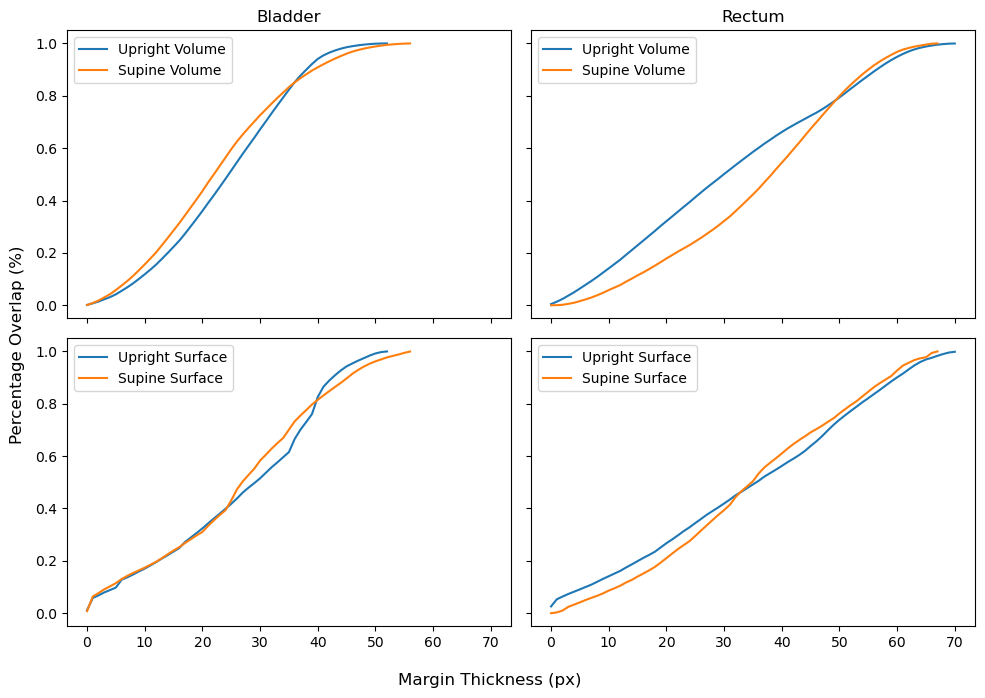

In [7]:
def marginDilationAnalysis(dmap, mask):
    sd = dmap[np.where(mask)]
    hsd = dmap[np.where(M.getSurface(mask))]

    vol, sa = [], []
    tVol = M.getVolume(mask)
    tSa = M.getSurfaceArea(mask)
    for i in range(np.ceil(np.max(sd)).astype(int)):
        vol.append(np.sum(sd <= i) / tVol)
        sa.append(np.sum(hsd <= i) / tSa)
    return vol, sa


prostate_dmapU = M.getDMap(masksU[3])
prostate_dmapS = M.getDMap(masksS[3])

bladder_volU, bladder_saU = marginDilationAnalysis(prostate_dmapU, masksU[0])
bladder_volS, bladder_saS = marginDilationAnalysis(prostate_dmapS, masksS[0])

rectum_volU, rectum_saU = marginDilationAnalysis(prostate_dmapU, masksU[4])
rectum_volS, rectum_saS = marginDilationAnalysis(prostate_dmapS, masksS[4])

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 7))
fig.supylabel("Percentage Overlap (%)")
fig.supxlabel("Margin Thickness (px)")

ax0.plot(bladder_volU, label="Upright Volume")
ax0.plot(bladder_volS, label="Supine Volume")
ax0.legend()

ax1.plot(rectum_volU, label="Upright Volume")
ax1.plot(rectum_volS, label="Supine Volume")
ax1.legend()

ax2.plot(bladder_saU, label="Upright Surface")
ax2.plot(bladder_saS, label="Supine Surface")
ax2.legend()

ax3.plot(rectum_saU, label="Upright Surface")
ax3.plot(rectum_saS, label="Supine Surface")
ax3.legend()

ax0.set_title("Bladder")
ax1.set_title("Rectum")

plt.tight_layout()

# Surface Distance Analysis

In [ ]:
sd = prostate_dmapU[np.where(masksU[0])]

m0Res = cumfreq(sd, numbins=100)
m0X = m0Res.lowerlimit + np.linspace(0, m0Res.binsize * m0Res.cumcount.size, m0Res.cumcount.size)

plt.figure()
plt.title("Bladder Distance Histogram")
plt.bar(m0X, m0Res.cumcount)
plt.show()

In [25]:
bladder_sdU = prostate_dmapU[np.where(masksU[0])]
bladder_sdS = prostate_dmapU[np.where(masksU[0])]

rectum_sdU = prostate_dmapU[np.where(masksU[4])]
rectum_sdS = prostate_dmapU[np.where(masksU[4])]

bladder_sdU_analysis, lbl = M.seriesAnalysis(bladder_sdU, labels=True)
bladder_sdS_analysis = M.seriesAnalysis(bladder_saS)

rectum_sdU_analysis = M.seriesAnalysis(rectum_sdU)
rectum_sdS_analysis = M.seriesAnalysis(rectum_sdS)

makeTable(
    ["Upright Bladder Surface Distance", "Supine Bladder Surface Distance"],
    [bladder_sdU_analysis, bladder_sdS_analysis],
    lbl,
    minWidth=8,
)
makeTable(
    ["Upright Rectum Surface Distance", "Supine Rectum Surface Distance"],
    [rectum_sdU_analysis, rectum_sdS_analysis],
    lbl,
    minWidth=8,
)

+----------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
|                                  | MIN      | P05      | P10      | AVG      | MDN      | P90      | P95      | MAX      |
+----------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
| Upright Bladder Surface Distance | 0.0      | 6.0      | 9.0      | 24.168   | 24.556   | 38.013   | 40.608   | 52.612   |
+----------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
| Supine Bladder Surface Distance  | 0.008    | 0.088    | 0.124    | 0.531    | 0.528    | 0.965    | 0.984    | 0.999    |
+----------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
+---------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
|

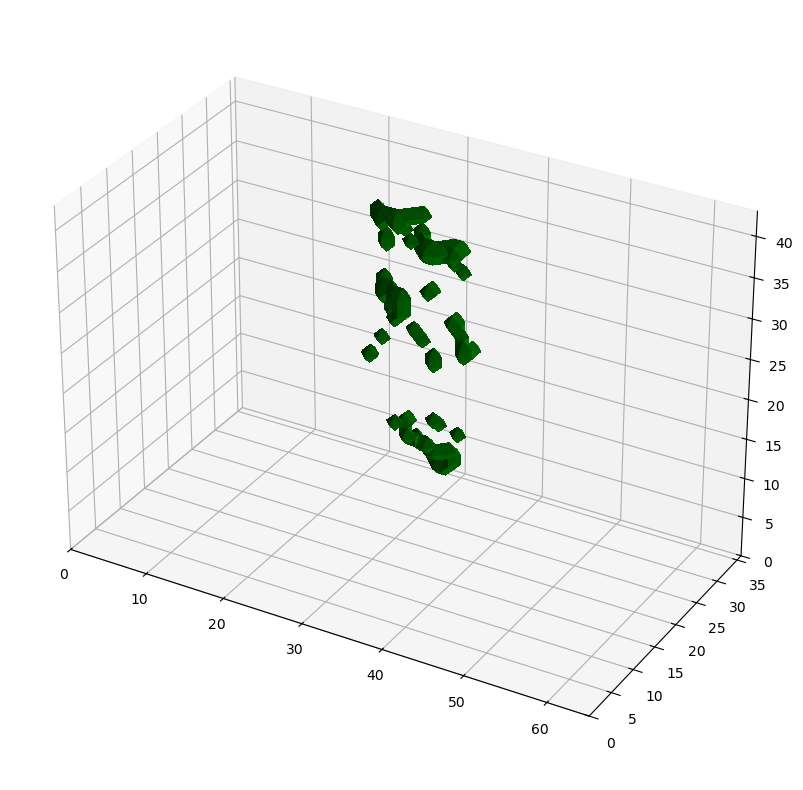

In [ ]:
rectum_fs = M.getFacingSurface(
    masksU[3], masksU[4], M.getSurface(masksU[3], idx=True), M.getSurface(masksU[4], idx=True)
)

show3D(rectum_fs, "")

In [ ]:
t0 = perf_counter()
m0_fs, m1_fs = M.getFacingSurfaces(m0, m1)
print(f"Time taken to compute surfaces: {(perf_counter() - t0):.3f}\n")

m0_fsp, m1_fsp = M.getFacingSurfacePercentage(m0, m1, facingS=m0_fs, facingT=m1_fs)

print(f"Mask0 Facing Surface Percentage: {(m0_fsp * 100):.3f}%")
print(f"Mask1 Facing Surface Percentage: {(m1_fsp * 100):.3f}%\n")

m0_fsd, m1_fsd = M.getFacingSurfaceDistance(m0, m1, m0_dmap, m1_dmap, facingS=m0_fs, facingT=m1_fs)

m0_fsd_analysis, lbl = M.seriesAnalysis(m0_fsd, labels=True)
m1_fsd_analysis = M.seriesAnalysis(m1_fsd)

m0Res = cumfreq(m0_fsd, numbins=100)
m0X = m0Res.lowerlimit + np.linspace(0, m0Res.binsize * m0Res.cumcount.size, m0Res.cumcount.size)

m1Res = cumfreq(m1_fsd, numbins=100)
m1X = m1Res.lowerlimit + np.linspace(0, m1Res.binsize * m1Res.cumcount.size, m1Res.cumcount.size)

plt.figure()
plt.title("M0 Surface Distance Histogram")
plt.bar(m0X, m0Res.cumcount)
plt.show()

plt.figure()
plt.title("M1 Surface Distance Histogram")
plt.bar(m1X, m1Res.cumcount)
plt.show()


for m0V, m1V, l in zip(m0_fsd_analysis, m1_fsd_analysis, lbl):
    print(f"Mask0 {l} Facing Surface Distance: {m0V:.3f}")
    print(f"Mask1 {l} Facing Surface Distance: {m1V:.3f}\n")

show3D(m0_fs | m1_fs)